# La Liga Data Analysis

## Package Requirements & Database

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import openpyxl
import seaborn as sns

In [3]:
with sqlite3.connect("../laliga.sqlite") as con:
    df=pd.read_sql_query("SELECT * FROM Matches",con)
    dr=pd.read_sql_query("SELECT * FROM Predictions",con)

## Exercises

### Exercise 1
**Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or there’s a tie) of all matches in the data. Write in the plot the percentage of each category.**

As can be seen in the pie chart below, it is indeed true that it is more likely for the home team to win, with a 52.8% chance. This is higher than the probability that there is a tie or that the away team wins.

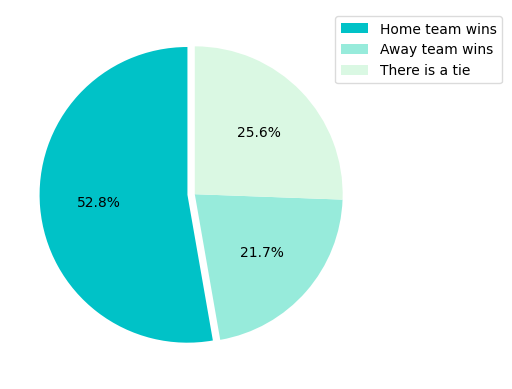

In [4]:
df = df.dropna(subset=['score'])

df["score_home_team"] = df["score"].str.split(":").str[0].astype(float)
df["score_away_team"] = df["score"].str.split(":").str[1].astype(float)

home_wins = (df['score_home_team'] > df['score_away_team']).sum()
away_wins = (df['score_home_team'] < df['score_away_team']).sum()
ties = (df['score_home_team'] == df['score_away_team']).sum()

sizes = [home_wins, away_wins, ties]
labels = ['Home team wins', 'Away team wins', 'There is a tie']
explode = (0.05, 0.0, 0.0)
colors = ['#00c2c7', '#97ebdb', '#daf8e3']

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(sizes, explode=explode, labels=['','',''], autopct='%1.1f%%', startangle=90, colors=colors)
ax.legend(wedges, labels, loc="upper right", bbox_to_anchor=(1.35, 1), fancybox=True, edgecolor='lightgrey', frameon=True)

plt.show()

### Exercise 2
**What are the top ten scoring teams of all time? What are the ten teams that concede the most? Make two bar plot charts showing each of them. Consider only matches played in 1st division. What have been the biggest wins? Of course, when we say _biggest_ we mean those with the highest goal difference. Show the top ten of them in a table.**

The ten highest scorers of the first division of La Liga can be seen in the two bar plot charts, respectively.

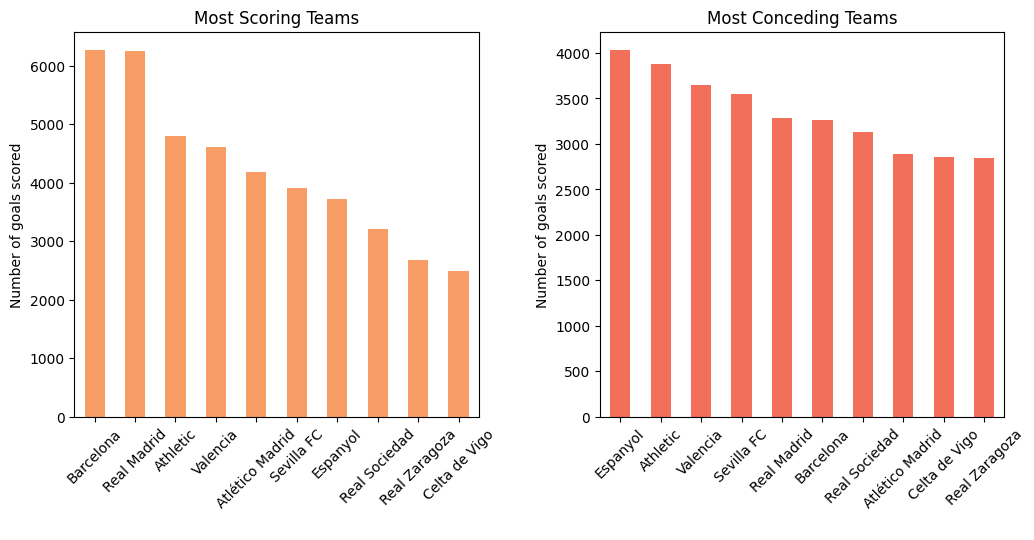

In [5]:
df_first_division = df[df['division'] == 1].copy()  # make a copy of the dataframe to avoid a warning

goals_scored = df_first_division.groupby('home_team')['score_home_team'].sum() + df_first_division.groupby('away_team')['score_away_team'].sum()
top_scorers = goals_scored.sort_values(ascending=False).head(10)

goals_conceded = df_first_division.groupby('home_team')['score_away_team'].sum() + df_first_division.groupby('away_team')['score_home_team'].sum()
top_conceders = goals_conceded.sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5)) # increase the figure size for wider subplots

plt.subplot(1, 2, 1)
top_scorers.plot(x='nombre', y='valor', kind='bar', color='#f79d65')
plt.xlabel(' ')
plt.ylabel('Number of goals scored')
plt.title('Most Scoring Teams')
plt.tick_params(axis='x', rotation=45)

plt.subplot(1, 2, 2)
top_conceders.plot(x='nombre', y='valor', kind='bar', color='#f27059')
plt.xlabel(' ')
plt.ylabel('Number of goals scored')
plt.title('Most Conceding Teams')
plt.tick_params(axis='x', rotation=45)

plt.subplots_adjust(wspace=0.3)  # add space between subplots
plt.show()

When it comes to the highest difference in scores per match in the first division, a table has also been created to display this information. As a highlight, the biggest difference there has ever been recorded until the moment the data was taken is 11 goals in an Athletic vs. Barcelona match.

In [6]:
df_first_division['score_difference'] = np.abs(df_first_division["score_home_team"] - df_first_division["score_away_team"])
df_first_division['game_name'] = df_first_division["home_team"] + ' vs ' + df_first_division["away_team"]
differences = df_first_division.iloc[:, -2:].sort_values(by='score_difference', ascending=False).head(10)

custom_column_names = {'score_difference': 'Score difference', 'game_name': 'Contestants'}
differences = differences.rename(columns=custom_column_names)
differences['Score difference'] = differences['Score difference'].astype(int)
differences.style.hide() # hide indeces

Score difference,Contestants
11,Athletic vs Barcelona
10,Sevilla FC vs Barcelona
10,Athletic vs Lérida
10,Athletic vs Celta de Vigo
10,Sevilla FC vs Real Oviedo
9,Barcelona vs Real Oviedo
9,Barcelona vs Rayo Vallecano
9,Racing vs Alavés
9,Real Madrid vs Elche CF
9,Atlético Madrid vs Hércules CF


### Exercise 3
**There has been a lot of discussion about how LaLiga’s television rights have changed game schedules in the last years. Make a bar plot chart showing the number of matches played each weekday, and make also a histogram of match time. Compare this two graphics between seasons 2000-2001 and 2020-2021.**

As can be seen in the bar plots below, this seems to indeed be the case if we consider the differences of the distributions number of games per day of the week in seasons 2000-2001 and 2020-2021. The games played in the 2000-2001 season are mostly concentrated around Saturday and Sunday, whereas the ones played in 2020-2021 are more distributed onto the weedays as well.

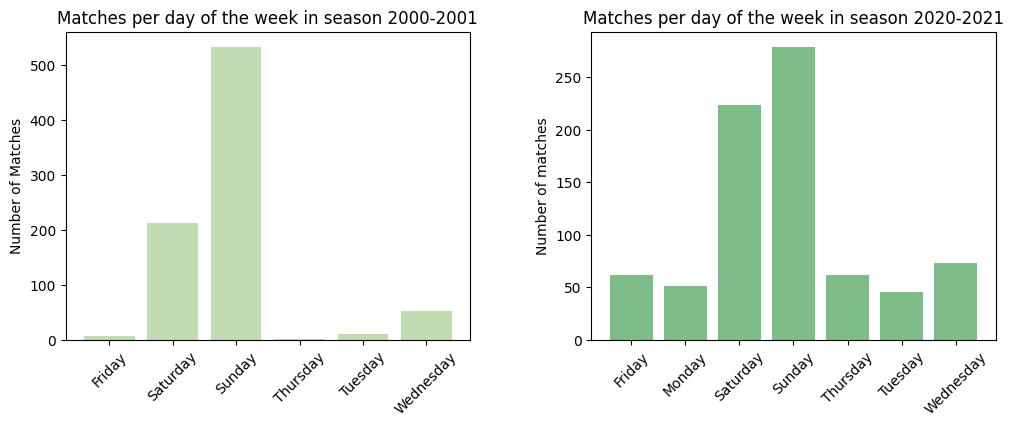

In [7]:
# Convert the 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')


# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Filter and plot data for 2000-2001
plt.subplot(1, 2, 1)
start_date_2000 = pd.Timestamp('2000-01-01')
end_date_2000 = pd.Timestamp('2000-12-31')
df_2000 = df[(df['date'] >= start_date_2000) & (df['date'] <= end_date_2000)]
day_of_week_counts_2000 = df_2000['date'].dt.day_name().value_counts().sort_index()
plt.bar(day_of_week_counts_2000.index, day_of_week_counts_2000, color='#c1dbb3')
plt.xlabel(' ')
plt.ylabel('Number of Matches')
plt.title('Matches per day of the week in season 2000-2001')
plt.tick_params(axis='x', rotation=45)

# Filter and plot data for 2020-2021
plt.subplot(1, 2, 2)
start_date_2020 = pd.Timestamp('2020-01-01')
end_date_2021 = pd.Timestamp('2020-12-31')
df_2020 = df[(df['date'] >= start_date_2020) & (df['date'] <= end_date_2021)]
day_of_week_counts_2020 = df_2020['date'].dt.day_name().value_counts().sort_index()
plt.bar(day_of_week_counts_2020.index, day_of_week_counts_2020, color='#7ebc89')
plt.xlabel(' ')
plt.ylabel('Number of matches')
plt.title('Matches per day of the week in season 2020-2021')
plt.tick_params(axis='x', rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)  # add space between subplots

plt.show()

A histogram of the times can be seen below.

**WE HAVE A PROBLEM HERE BELOW STILL, TO BE FIXED**

In [8]:
df["date"] = pd.to_datetime(df["date"], format = "%m/%d/%y")
df["time"] = pd.to_datetime(df["time"], format = "%I:%M %p", errors = "coerce").dt.strftime("%H:%M")



In [9]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y')

start_date_2000 = pd.Timestamp('2000-01-01')
end_date_2000 = pd.Timestamp('2000-12-31')
df_2000 = df[(df['date'] >= start_date_2000) & (df['date'] <= end_date_2000)].copy()

df_2000['time'] = df_2000['time'].astype(str)
match_times = df_2000['time'].str.extract(r'(\d+):(\d+)').astype(float)
print(match_times)

        0   1
17628 NaN NaN
17629 NaN NaN
17630 NaN NaN
17631 NaN NaN
17632 NaN NaN
...    ..  ..
38429 NaN NaN
38430 NaN NaN
38431 NaN NaN
38432 NaN NaN
38433 NaN NaN

[819 rows x 2 columns]


### Exercise 4

**Build a cross results table for season 2020-2021 (1st division). Figure 1 in the instructions is an example taken from Wikipedia. Try to make it the most similar to this one, painting the background of each cell according to result (green in case local team wins and red in case visitor team wins). Also, could you model the intensity of this background color with the goal difference from the match? Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_table(season, division) and return the plot object.**

The code below, when executed, displays a cross table in which if the home team wins the background is color green, if the away team wins the background color is red and if there is a tie the background color is orange. 

In [10]:
#here we are creating a data frame with the results from the first division in season 2020-2021
df_season20_21=df_first_division[df_first_division['season']=='2020-2021'] 
#creation of the table
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')

#function for coloring the table according to who wins de match
def coloring(value):
    if value=='-':
        return '' #the values of the table with '-' don't get coloured!!
    else:
        parts=value.split(":") #we are extracting the ':' in order to be able to compare scores!!!
        home_score=int(parts[0])
        away_score=int(parts[1])  
        if home_score>away_score:
            return 'background-color: rgba(144, 238, 144,0.55)'
        if home_score<away_score:
            return 'background-color: rgba(255, 37, 44,0.7)'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring) 
display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Could you model the intensity of this background color with the goal difference from the match?

The code below does the same as the one in the cell above, but now we asign a difference intensity of the code according to the value of the difference between the score of the home team and the away team: as more different are the scores, the brighter the color gets.

In [11]:
df_season20_21=df_first_division[df_first_division['season']=='2020-2021']
table=df_season20_21.pivot(index='home_team', columns='away_team',values='score')
table=table.fillna('-')
#here we are calculating the maximum diference between scores that there is when the home team wins and when the away team wins
max_dif_homewins=(df_season20_21['score_home_team']-df_season20_21['score_away_team']).max()
max_dif_awaywins=(-df_season20_21['score_home_team']+df_season20_21['score_away_team']).max()

#function for coloring, now with gradients :)
def coloring_gradients(value):
    if value=='-':
        return '' 
    else:
        parts=value.split(":")
        home_score=float(parts[0])
        away_score=float(parts[1])
        if home_score>away_score:
            alpha=(home_score-away_score)/max_dif_homewins #this is the transparency that the cell acquires, as more difference, the less transparency there is
            if alpha>=0.8:
                return f'background-color:rgba(144, 238, 144, {alpha});color:black' #so the letters can be read!!!
            else:
                return f'background-color:rgba(144, 238, 144, {alpha});color:white'  
        if home_score<away_score:
            alpha=(-home_score+away_score)/max_dif_awaywins
            return f'background-color:rgba(255, 37, 44, {alpha})'
        if home_score==away_score:
            return 'background-color:rgb(255,179,71); color:black'
    
colored_table=table.style.map(coloring_gradients)

display(colored_table)

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


#### Write a function that, given the season and the division, plots the cross section results table

Since we have two types of table created, we have two functions according to the type of colors you want (if you want the gradient or not).

Table without the gradient:

In [12]:
def table_for_any_season(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table=table_any_seas.style.map(coloring) 
    return colored_table
#If you want to try the function with more values make sure to put first the number of the division (1 or 2) and the season with format 'year-year'
display(table_for_any_season(1,'2013-2012')) 

away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


Table with the gradient:

In [13]:
def table_for_any_season_with_gradient(x,y):
    df_unknown_div= df[df['division']==x]
    df_any_season=df_unknown_div[df_unknown_div['season']==y]
    table_any_seas=df_any_season.pivot_table(index='home_team', columns='away_team',values='score',aggfunc=list,fill_value='-',margins=False)
    table_any_seas=table.fillna('-')
    colored_table_gradient=table_any_seas.style.map(coloring_gradients) 
    return colored_table_gradient
#same recquirements as before, first write the function (1 or 2) and then the season as 'year-year'
display(table_for_any_season_with_gradient(2,'2001-2000'))


away_team,Alavés,Athletic,Atlético Madrid,Barcelona,CA Osasuna,Celta de Vigo,Cádiz CF,Elche CF,Getafe,Granada CF,Levante,Real Betis,Real Madrid,Real Sociedad,Real Valladolid,SD Eibar,SD Huesca,Sevilla FC,Valencia,Villarreal
home_team,,,,,,,,,,,,,,,,,,,,
Alavés,-,1:0,1:2,1:1,0:1,1:3,1:1,0:2,0:0,4:2,2:2,0:1,1:4,0:0,1:0,2:1,1:0,1:2,2:2,2:1
Athletic,0:0,-,2:1,2:3,2:2,0:2,0:1,1:0,5:1,2:1,2:0,4:0,0:1,0:1,2:2,1:1,2:0,2:1,1:1,1:1
Atlético Madrid,1:0,2:1,-,1:0,2:1,2:2,4:0,3:1,1:0,6:1,0:2,2:0,1:1,2:1,2:0,5:0,2:0,2:0,3:1,0:0
Barcelona,5:1,2:1,0:0,-,4:0,1:2,1:1,3:0,5:2,1:2,1:0,5:2,1:3,2:1,1:0,1:1,4:1,1:1,2:2,4:0
CA Osasuna,1:1,1:0,1:3,0:2,-,2:0,3:2,2:0,0:0,3:1,1:3,0:2,0:0,0:1,0:0,2:1,1:1,0:2,3:1,1:3
Celta de Vigo,2:0,0:0,0:2,0:3,2:1,-,4:0,3:1,1:0,3:1,2:0,2:3,1:3,1:4,1:1,1:1,2:1,3:4,2:1,0:4
Cádiz CF,3:1,0:4,2:4,2:1,0:2,0:0,-,1:3,0:2,1:1,2:2,0:1,0:3,0:1,0:0,1:0,2:1,1:3,2:1,0:0
Elche CF,0:2,2:0,0:1,0:2,2:2,1:1,1:1,-,1:3,0:1,1:0,1:1,1:1,0:3,1:1,1:0,0:0,2:1,2:1,2:2
Getafe,0:0,1:1,0:0,1:0,1:0,1:1,0:1,1:1,-,0:1,2:1,3:0,0:0,0:1,0:1,0:1,1:0,0:1,3:0,1:3


### Exercise 5

**As you surely know, there has always been a historical rivalry between Barcelona and Real Madrid. But which of them has won the most games in direct confrontations? Which of them has scored the most goals in these games? Show both things in two pie charts, side by side. Remember to consider ties in the first one. Write a function that, given two team names, plots the two graphs described above. Function prototype should be like plot_direct_confrontations_- stats(team1, team2) and return the plot object. Use it with some other classical rivals like Betis and Sevilla.**

In direct confrontations, the data reflects that Madrid has won more by a very small difference. The same is true for the number of goals scored. However, the difference is in the order of 0.5% in both cases, which keeps future games very interesting with remarkably tie odds of winning.

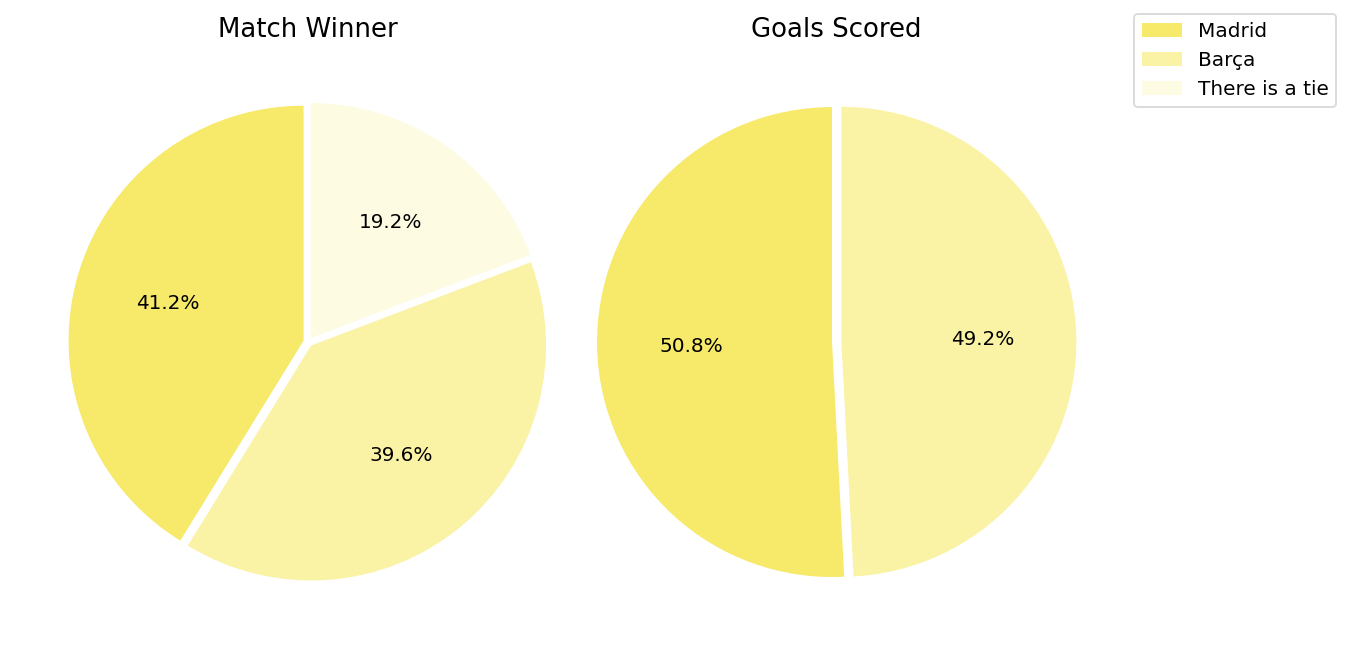

In [14]:
df_home_madrid = df[df['home_team'] == 'Real Madrid'] [df[df['home_team'] == 'Real Madrid'] ['away_team'] == 'Barcelona']
goals_madrid = df_home_madrid['score_home_team'].sum()
df_home_barca = df[df['home_team'] == 'Barcelona'] [df[df['home_team'] == 'Barcelona'] ['away_team'] == 'Real Madrid']
goals_barca = df_home_barca['score_home_team'].sum()

df_bar_vs_mad = pd.concat([df_home_madrid, df_home_barca])

madrid_wins = (df_home_madrid['score_home_team'] > df_home_madrid['score_away_team']).sum() + (df_home_barca['score_home_team'] < df_home_barca['score_away_team']).sum()
barca_wins = (df_home_barca['score_home_team'] > df_home_barca['score_away_team']).sum() + (df_home_madrid['score_home_team'] < df_home_madrid['score_away_team']).sum()
ties = (df_bar_vs_mad['score_home_team'] == df_bar_vs_mad['score_away_team']).sum()


fig = plt.figure(figsize=(10, 10), dpi=144)

sizes = [madrid_wins, barca_wins, ties]
labels = [' ', ' ', ' ']
explode = (0.02, 0.02, 0.02)  # controls how much the wedges come out
plt.subplot(1, 2, 1)
colors1 = ['#f7e969', '#faf2a5', '#fdfbe1']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors1)
plt.title('Match Winner', fontsize=13)

sizes = [goals_madrid, goals_barca]
labels = [' ', ' ']
explode = (0.02, 0.02)
plt.subplot(1, 2, 2)
colors2 = ['#f7e969', '#faf2a5']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors2)
plt.title('Goals Scored', fontsize=13)

plt.subplots_adjust(wspace=-0.1)
legend_labels = ['Madrid', 'Barça', 'There is a tie']
legend_colors = ['#f7e969', '#faf2a5', '#fdfbe1', '#f7e969', '#faf2a5']
fig.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.05, 0.73), prop={'size': 10}, fancybox=True, edgecolor='lightgrey', frameon=True)

plt.show()

Below is the function by which the action of comparing the statistics of the direct confrontation of two teams in LaLiga can be seen. As an example, it is called for Real Betis vs. Sevilla FC.

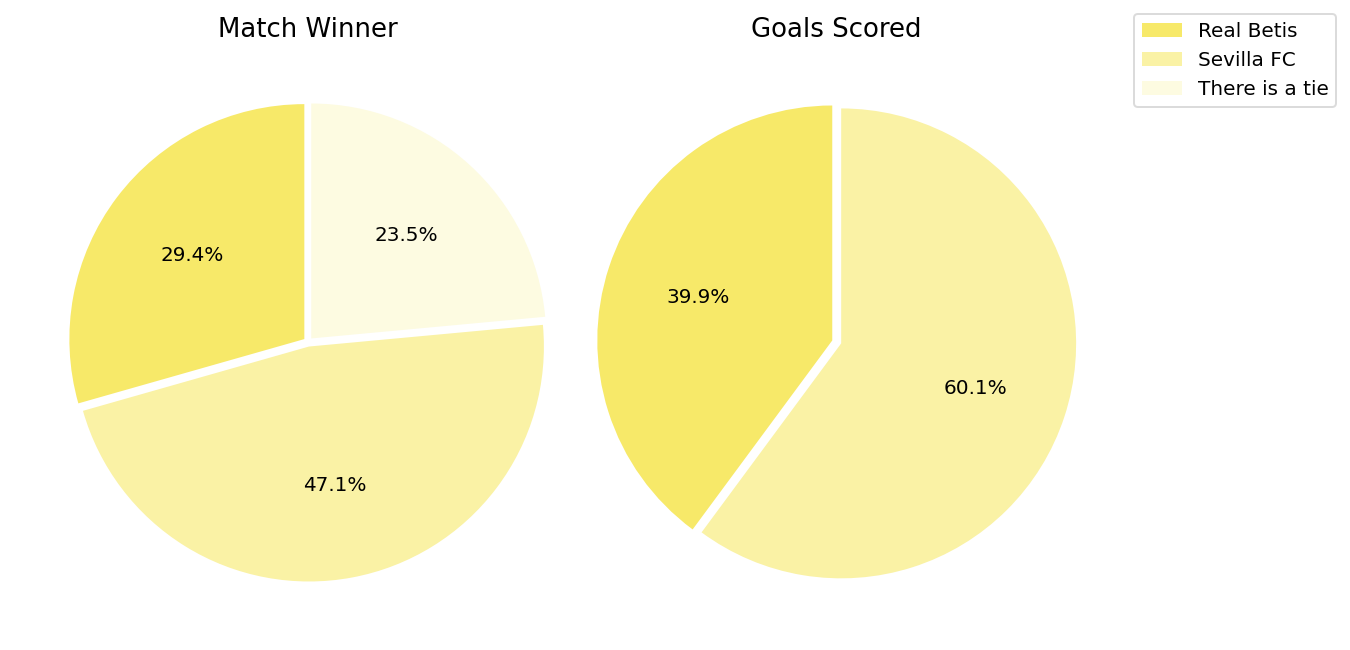

In [15]:
#function exercise 5
def plot_direct_confontations_stats(team1,team2):
    df_home_team1 = df[df['home_team'] == team1] [df[df['home_team'] == team1] ['away_team'] == team2]
    goals_team1 = df_home_team1['score_home_team'].sum()
    df_home_team2 = df[df['home_team'] == team2] [df[df['home_team'] == team2] ['away_team'] == team1]
    goals_team2 = df_home_team2['score_home_team'].sum()

    df_team1_vs_team2 = pd.concat([df_home_team1, df_home_team2])

    team1_wins = (df_home_team1['score_home_team'] > df_home_team1['score_away_team']).sum() + (df_home_team2['score_home_team'] < df_home_team2['score_away_team']).sum()
    team2_wins = (df_home_team2['score_home_team'] > df_home_team2['score_away_team']).sum() + (df_home_team1['score_home_team'] < df_home_team1['score_away_team']).sum()
    ties = (df_team1_vs_team2['score_home_team'] == df_team1_vs_team2['score_away_team']).sum()

    fig = plt.figure(figsize=(10,10),dpi=144)

    sizes = [team1_wins, team2_wins, ties]
    labels = [' ', ' ', ' ']
    explode = (0.02, 0.02, 0.02)  # controls how much the wedges come out
    plt.subplot(1, 2, 1)
    colors1 = ['#f7e969', '#faf2a5', '#fdfbe1']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors1)
    plt.title('Match Winner', fontsize=13)

    sizes = [goals_team1, goals_team2]
    labels = [' ', ' ']
    explode = (0.02, 0.02)
    plt.subplot(1, 2, 2)
    colors2 = ['#f7e969', '#faf2a5']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, explode=explode, colors=colors2)
    plt.title('Goals Scored', fontsize=13)

    plt.subplots_adjust(wspace=-0.1)
    legend_labels = [f'{team1}', f'{team2}', 'There is a tie']
    legend_colors = ['#f7e969', '#faf2a5', '#fdfbe1', '#f7e969', '#faf2a5']
    fig.legend(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.05, 0.73), prop={'size': 10}, fancybox=True, edgecolor='lightgrey', frameon=True)

    plt.show()

plot_direct_confontations_stats('Real Betis','Sevilla FC')


### Exercise 6
**Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the longest undefeated streaks in a horizontal bar plot, indicating in each bar the team name and the dates it held that streak, for instance, Real Sociedad 22/04/1979 - 04/05/1980.**

In [16]:
df.head()

,season,division,matchday,date,time,home_team,away_team,score,score_home_team,score_away_team
0,1928-1929,1,1,2029-02-10,NaN,Arenas Club,Athletic Madrid,2:3,2.0,3.0
1,1928-1929,1,1,2029-02-10,NaN,Espanyol,Real Unión,3:2,3.0,2.0
2,1928-1929,1,1,2029-02-10,NaN,Real Madrid,Catalunya,5:0,5.0,0.0
3,1928-1929,1,1,2029-02-10,NaN,Donostia,Athletic,1:1,1.0,1.0
4,1928-1929,1,1,2029-02-12,NaN,Racing,Barcelona,0:2,0.0,2.0


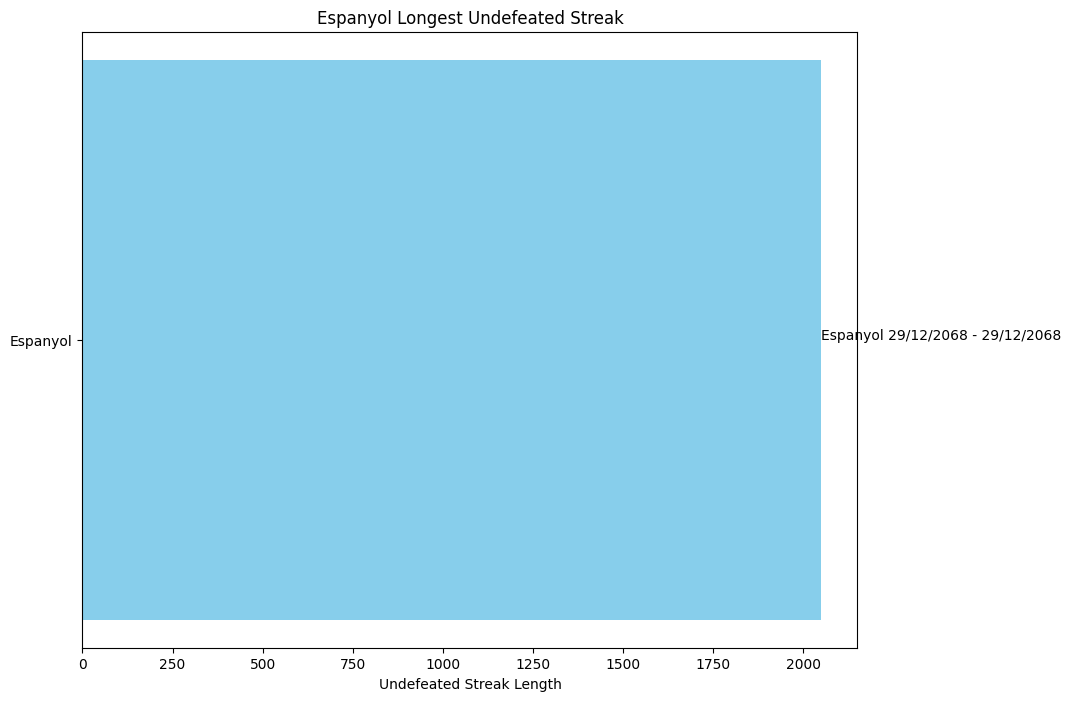

In [17]:
# PROVA AMB ASSISTENT CHAGPT

import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'df' with columns 'home_team', 'away_team', 'date', 'home_score', 'away_score'

# Specify the team you want to analyze
target_team = 'Espanyol'

# Create a new DataFrame for the specific team's results as home and away
home_results = df[df['home_team'] == target_team][['home_team', 'date', 'score_home_team']].rename(columns={'home_team': 'team', 'score_home_team': 'score'})
home_results['result'] = home_results['score'].apply(lambda x: 1 if x > 0 else 0)

away_results = df[df['away_team'] == target_team][['away_team', 'date', 'score_away_team']].rename(columns={'away_team': 'team', 'score_away_team': 'score'})
away_results['result'] = away_results['score'].apply(lambda x: 1 if x > 0 else 0)

# Combine home and away results for the specific team
combined_results = pd.concat([home_results, away_results])

# Sort the DataFrame by 'team' and 'date'
combined_results.sort_values(['team', 'date'], inplace=True)

# Calculate the consecutive undefeated streak for the specific team when it wins
combined_results['streak'] = combined_results.groupby('team')['result'].cumsum()

# Find the longest undefeated streak for the specific team
max_streak = combined_results['streak'].max()
longest_streak = combined_results[combined_results['streak'] == max_streak]

# Get the corresponding start and end dates for the longest streak
start_date = longest_streak['date'].iloc[0].strftime('%d/%m/%Y')
end_date = longest_streak['date'].iloc[-1].strftime('%d/%m/%Y')

# Plot the results in a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh([target_team], max_streak, color='skyblue')
plt.xlabel('Undefeated Streak Length')
plt.title(f'{target_team} Longest Undefeated Streak')
plt.text(max_streak + 1, 0, f"{target_team} {start_date} - {end_date}")
plt.gca().invert_yaxis()  # Reverse the order to show the longest streak at the top
plt.show()


### Exercise 7
**Create a table with the final standings of each season (and division), that is, a table that contains all the teams ordered (in descending order) by the number of points they got during that season, and some other aggregate statistics. The table must contain the following columns: season, division, ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that standings of one season come before standings of previous one, and standings of 1st division come before standings of 2nd division.**


In [18]:
df['Winner'] = np.where(df['score_home_team'] > df['score_away_team'], 1, np.where(df['score_home_team'] < df['score_away_team'], 0, -1))

def func_home_wins(data):
    return (data[data == 1]).count()

def func_away_wins(data):
    return (data[data == 0]).count()

def func_tie(data):
    return (data[data == -1]).count()

df_class_home = df.groupby(['division', 'season', 'home_team']).agg(
    GF=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    W=pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    L=pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    T=pd.NamedAgg(column='Winner', aggfunc=func_tie)
).reset_index()

df_class_away = df.groupby(['division', 'season', 'away_team']).agg(
    GF=pd.NamedAgg(column='score_away_team', aggfunc='sum'),
    GA=pd.NamedAgg(column='score_home_team', aggfunc='sum'),
    W=pd.NamedAgg(column='Winner', aggfunc=func_away_wins),
    L=pd.NamedAgg(column='Winner', aggfunc=func_home_wins),
    T=pd.NamedAgg(column='Winner', aggfunc=func_tie)
).reset_index()

df_class_away.rename(columns={'away_team': 'team'}, inplace=True)
df_class_home.rename(columns={'home_team': 'team'}, inplace=True)

df_classification = df_class_away.merge(df_class_home, how='outer')
df_classification = df_classification.groupby(['season', 'team', 'division']).sum().reset_index()

df_classification['GD'] = df_classification['GF'] - df_classification['GA']
df_classification['Pts'] = (df_classification['W']) * 3 + df_classification['T']

df_classification['year_of_start'] = df_classification['season'].str.split("-").str[0].astype(int)

df_classification_ordered = df_classification.sort_values(by=['year_of_start'], ascending=False)
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division'], ascending=[False, True])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts'], ascending=[False, True, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD'], ascending=[False, True, False, False])
df_classification_ordered = df_classification_ordered.sort_values(by=['year_of_start', 'division', 'Pts', 'GD', 'GF'], ascending=[False, True, False, False, False])

df_classification_ordered = df_classification_ordered.reset_index(drop=True)
df_classification_ordered['ranking'] = df_classification_ordered.groupby(['year_of_start', 'division']).cumcount() + 1

df_final_classification_ordered = df_classification_ordered.drop(columns=['year_of_start'])

df_final_classification_ordered.reset_index(drop=True, inplace=True)
df_final_classification_ordered.index += 1
df_final_classification_ordered.to_excel('SeasonStandings.xlsx', index=False)

### Exercise 8

##### Villarreal is a team that has grown a lot in recent decades. Specially ever since some billionaire guy bought it (Fernando Roig, from Mercadona). Make a line plot showing the rank of Villarreal at the end of each season, from the oldest ones (left) to the earliest ones (right). Consider rankings in 2nd division to be a continuation of the 1st one, that is, if there’s N teams in 1st division and Villarreal got r position in 2nd division, then it should be placed in N +r. Draw in the same plot a line showing the cut between 1st and 2nd division



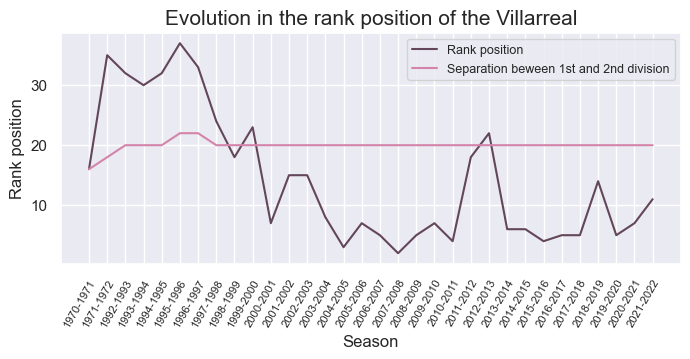

In [19]:
#obtainig the data of 
df_villarreal_1=df_final_classification_ordered[(df_final_classification_ordered['team']=='Villarreal')&(df_final_classification_ordered['division']==1.0)]

#now, we will work with division 2 
#this is for having the data of years in which villarreal is in division 2
df_villarreal_2=df_final_classification_ordered[(df_final_classification_ordered['team']=='Villarreal')&(df_final_classification_ordered['division']==2.0)]
seasons_villarreal_2= df_villarreal_2['season']

#df of all the teams that were in first division when villarreal was in division 2 
df_total_v2=df_final_classification_ordered[(df_final_classification_ordered['season'].isin(seasons_villarreal_2))&df_final_classification_ordered['division']==1.0]
#taking the lowest rank position for each season so we can sum the position in div 2 to it
lowest_rank_div1= df_total_v2.groupby(['season'])['ranking'].max().reset_index()
df_villarreal_2=df_villarreal_2.merge(lowest_rank_div1,how='outer')
df_villarreal_2_final=df_villarreal_2.groupby(['season']).sum().reset_index()

#joining both df and sorting them out by year (so we can use the data for the plot!!)
df_villarreal= df_villarreal_1.merge(df_villarreal_2_final,how='outer')
df_villarreal['year_start']=df_villarreal['season'].str.split('-').str[0].astype(int)
df_villarreal_ordered=df_villarreal.sort_values(by=['year_start'],ascending=[True])


#here we are obtaining the lowest ranking for each season so we can plot the line that divides division 1 and 2!!
total_seasons_villarreal=df_villarreal_ordered['season']
df_total=df_final_classification_ordered[(df_final_classification_ordered['season'].isin(total_seasons_villarreal))]
df_total_div1=df_total[df_total['division']==1]
df_total_lowest_in_rank_div1=df_total_div1.groupby(['season'])['ranking'].max().reset_index()
#changing the name of the column of the lowest ranking so it doesn't do weird things with column 'ranking' 
df_total_lowest_in_rank_div1_renamed=df_total_lowest_in_rank_div1.rename(columns={'ranking':'lowest_in_1'})
df_villarreal_ordered=df_villarreal_ordered.merge(df_total_lowest_in_rank_div1_renamed, on='season',how='inner')


#plotting the graphic!!! 
sns.set_theme()
fig=plt.figure(figsize=(8,3))
sns.lineplot(data=df_villarreal_ordered,x='season',y='ranking',color="#63465A",label='Rank position')
plt.xticks(rotation=60, ha='right',rotation_mode='anchor', fontsize=8)
plt.xlabel('Season')
plt.ylabel('Rank position')
sns.lineplot(data=df_villarreal_ordered,x='season',y='lowest_in_1',label='Separation beween 1st and 2nd division',color='#d484aa')


plt.legend(fontsize=9)
plt.title('Evolution in the rank position of the Villarreal',fontsize=15)
plt.show()

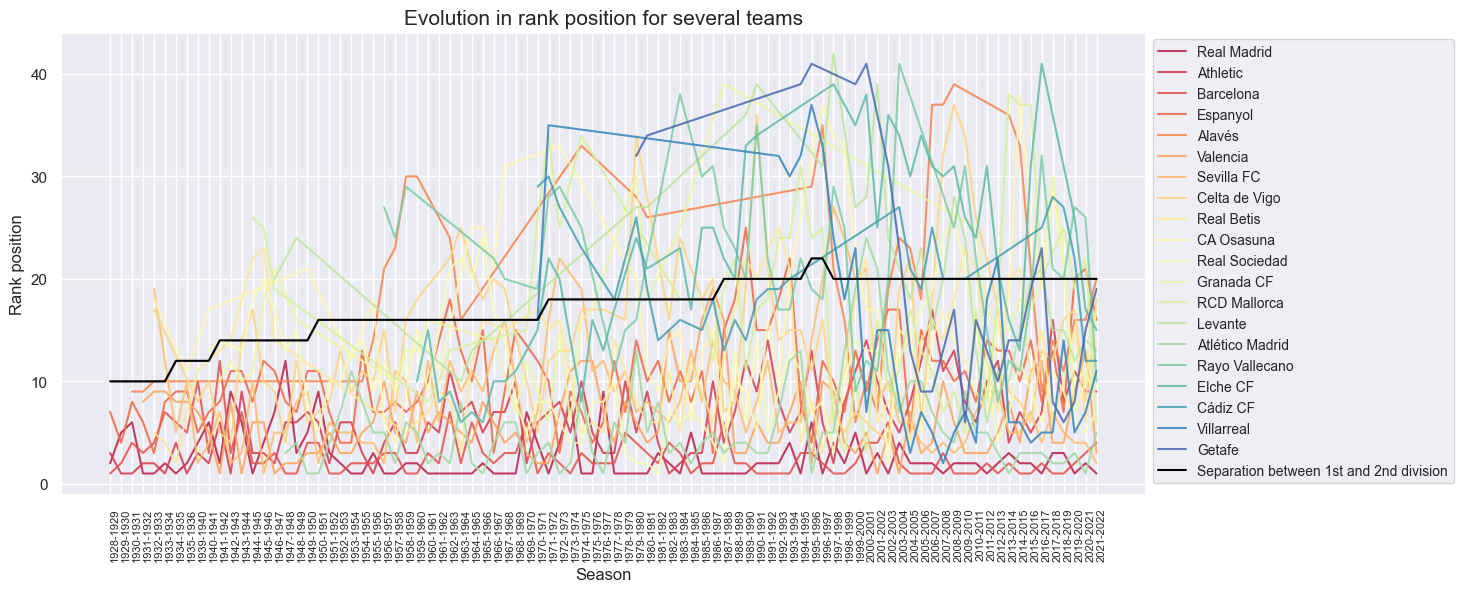

In [36]:


#function that works in the same way as the code above, but with several teams
def plot_ranking_evolution(*teams):
    df_plot=pd.DataFrame() #defining an empty df that helps us ataching the data of the funcion into it!!
     
    for team in teams:
        #this is the same procedure as in the code above, but for an undefined team 
        df_current_iter=df_final_classification_ordered[df_final_classification_ordered['team']==team]
        df_plot_div1=df_current_iter[df_current_iter['division']==1.0]
        df_plot_div2=df_current_iter[df_current_iter['division']==2.0]
        seasons_team_div2=df_plot_div2['season']
        df_team_in2=df_final_classification_ordered[df_final_classification_ordered['season'].isin(seasons_team_div2)]
        df_team_in2_div1=df_team_in2[df_team_in2['division']==1.0]
        lowest_rank_div1=df_team_in2_div1.groupby('season')['ranking'].max().reset_index()
        df_plot_div2=df_plot_div2.merge(lowest_rank_div1,how='outer')
        df_plot_div2_final= df_plot_div2.groupby(['season']).sum().reset_index()
        df_team=df_plot_div1.merge( df_plot_div2_final,how='outer')
        df_plot=pd.concat([df_plot,df_team]) #attaching all the data to the same dataframe 
    #ordering the dataframe according to the season!!
    df_plot['year_start']=df_plot['season'].str.split('-').str[0].astype(int)
    df_plot_ordered=df_plot.sort_values(by=['year_start'],ascending=[True])
    
    #same as before, but now we have the dataframe for all the teams we want to display!!
    total_seasons_plot=df_plot_ordered['season']
    df_all_seasons=df_final_classification_ordered[(df_final_classification_ordered['season'].isin(total_seasons_plot))]
    df_all_seasons_div1=df_all_seasons[df_all_seasons['division']==1.0]
    df_total_lowest_in_rank=df_all_seasons_div1.groupby(['season'])['ranking'].max().reset_index()
    df_total_lowest_in_rank_renamed=df_total_lowest_in_rank.rename(columns={'ranking':'lowest_in_1'})
    df_plot_ordered=df_plot_ordered.merge(df_total_lowest_in_rank_renamed,on='season',how='inner')
    

    #plotting the graphic again!! :)
    sns.set_theme()
    fig=plt.figure(figsize=(14,6))
    sns.lineplot(data=df_plot_ordered,x='season',y='ranking',hue='team',palette='Spectral',alpha=0.85)
    sns.lineplot(data=df_plot_ordered,x='season',y='lowest_in_1',color='black',label='Separation between 1st and 2nd division')
    plt.xticks(rotation=90, ha='right',rotation_mode='anchor', fontsize=8)
    plt.xlabel('Season')
    plt.ylabel('Rank position')
    plt.legend( bbox_to_anchor=(1, 1), loc='upper left',fontsize=10)
    plt.title('Evolution in rank position for several teams', fontsize=15)
    plt.show()



    

#for ploting the ranking evolution of several teams, if you want to play with it, remember to use the format ('team',...)!!
plot_ranking_evolution('Atlético Madrid', 'CA Osasuna', 'Villarreal', 'Celta de Vigo', 'Granada CF', 'Espanyol', 'Real Betis', 'Real Sociedad', 'Elche CF', 'Barcelona', 'Sevilla FC', 'Levante', 'RCD Mallorca', 'Valencia', 'Cádiz CF', 'Real Sociedad', 'Rayo Vallecano', 'Alavés', 'Athletic', 'Getafe', 'Real Madrid')

### Exercise 9

**In football jargon, those teams that are permanently descending and ascending between 1st and 2nd division are called elevator teams. What are the most elevator teams in LaLiga? Plot the history of the top 5 of them using the function from exercise 8.**

The top 5 most 'elevator teams' in history is Barcelona, Athletic, Real Madrid, Espanyol and Valencia.

The most elevator teams in LaLiga are: ['Racing', 'CA Osasuna', 'Real Betis', 'UD Las Palmas', 'Real Oviedo']


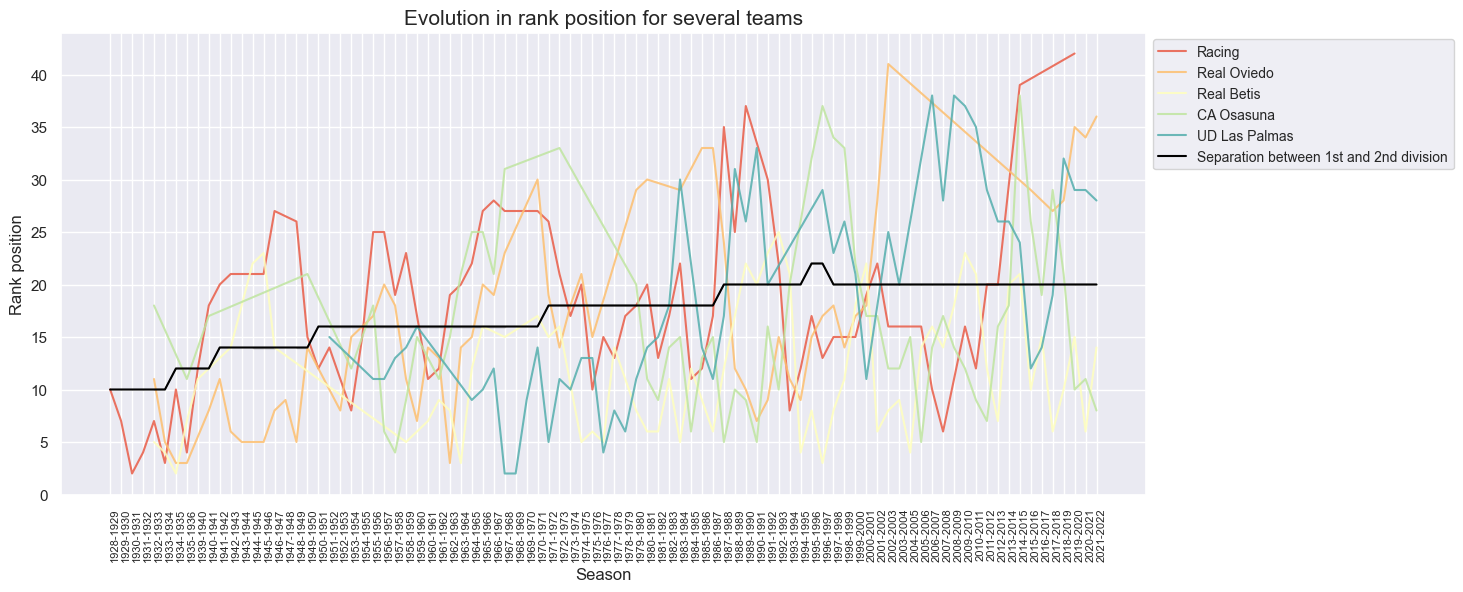

In [37]:
#function that counts the division shifts of a team!
def division_changes(data):
    return ((data != data.shift()).astype(int)).count()
#applying the function to our teams of every season!!! 
df_division_changes = df.groupby(['home_team','season'])['division'].agg(division_changes).reset_index()
df_top5_elevator_teams = df_division_changes.sort_values(by='division', ascending=False).head(5).reset_index()

#creating a list
list_elevator_teams = df_top5_elevator_teams['home_team'].tolist()

print('The most elevator teams in LaLiga are:', list_elevator_teams)

plot_ranking_evolution('Racing', 'CA Osasuna', 'Real Betis', 'UD Las Palmas', 'Real Oviedo')


### Exercise 10